# Mask to polygons

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#export
from xview2comp.nb_02b import *
import imantics
from simplification.cutil import simplify_coords_vwp
from uuid import uuid4
import tqdm

In [4]:
show_install(True)



```text
=== Software === 
python       : 3.7.4
fastai       : 1.0.59
fastprogress : 0.1.21
torch        : 1.2.0
torch cuda   : None / is **Not available** 

=== Hardware === 
No GPUs available 

=== Environment === 
platform     : Darwin-19.0.0-x86_64-i386-64bit
conda env    : fastai_dev
python       : /Users/jack/anaconda3/envs/fastai_dev/bin/python
sys.path     : /Users/jack/git_repos/xview2comp
/Users/jack/anaconda3/envs/fastai_dev/lib/python37.zip
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/lib-dynload

/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages
/Users/jack/anaconda3/envs/fastai_dev/lib/python3.7/site-packages/IPython/extensions
/Users/jack/.ipython
../course-v3/nbs/dl2
no supported gpus found on this system
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.



In this notebook, we will:
* Convert a binary mask to a list/table of polygons in it.
* Generate a unique id for each of the polygon.
* For each polygon, crop out the part of the original image that lies underneath the polygon -- which we call the *polygon image*.
* Save each polygon image in an .png file named after its polygon's unique id.

In [5]:
SOURCE = Path('data/train/')
SOURCE.ls()

[PosixPath('data/train/train.tar.gz'),
 PosixPath('data/train/images'),
 PosixPath('data/train/damagemasks'),
 PosixPath('data/train/labels'),
 PosixPath('data/train/classification_images'),
 PosixPath('data/train/binarymasks')]

In [6]:
npreimgs = pre_img_fpaths(get_image_files(SOURCE/'images'))
npreimgs[:3]

[PosixPath('data/train/images/hurricane-harvey_00000015_pre_disaster.png'),
 PosixPath('data/train/images/hurricane-harvey_00000228_pre_disaster.png'),
 PosixPath('data/train/images/hurricane-michael_00000261_pre_disaster.png')]

In [7]:
nposimgs = [pre2post_fpath(n) for n in npreimgs]
nposimgs[:3]

[PosixPath('data/train/images/hurricane-harvey_00000015_post_disaster.png'),
 PosixPath('data/train/images/hurricane-harvey_00000228_post_disaster.png'),
 PosixPath('data/train/images/hurricane-michael_00000261_post_disaster.png')]

In [8]:
nposlabs = [img2label_fpath(n) for n in nposimgs]
nposlabs[:3]

[PosixPath('data/train/labels/hurricane-harvey_00000015_post_disaster.json'),
 PosixPath('data/train/labels/hurricane-harvey_00000228_post_disaster.json'),
 PosixPath('data/train/labels/hurricane-michael_00000261_post_disaster.json')]

### Grab a single sample  

Grab a single sample from the training set.  Get the paths to the pre-disaster image, the post-disaster image, the binary mask (which is made from the pre-disaster image's annotations).

In [9]:
idx = 28

In [10]:
npreimg = npreimgs[idx]
nposimg = pre2post_fpath(npreimgs[idx])
nbmask = img2bmask_fpath(npreimg)

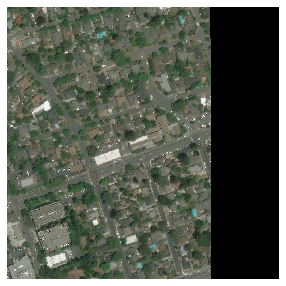

In [11]:
open_image(npreimg).show(figsize=(5, 5))

In [12]:
bmask = open_mask(nbmask)

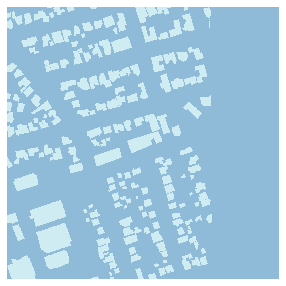

In [13]:
bmask.show(figsize=(5, 5))

#### Convert binary mask to polygon

This was already outlined in *01_load_data.ipynb*. Here, the procedures defined there are refactored into functions.

In [69]:
#export
def bmask2polys(mask):
    '''
    Convert mask to polys.
    mask: 2d numpy.ndarray 
    ps: np.array of np.arrays, containing all polygons', 
        their vertices' (x, y) coordinates.
    '''
    sz = mask.shape[0]
    ps = imantics.Mask(mask).polygons()
    ps = (p for p in ps if len(p) >= 3)
    ps = (p.reshape(-1, 2) for p in ps)
    ps = (simplify_coords_vwp(p, .3).astype(np.int32) for p in ps)
    ps = (p for p in ps if len(p) > 2)
    ps = (np.concatenate((p, p[0][None,...])) for p in ps)
    return sz, np.array(list(ps))

In [70]:
sz, polys = bmask2polys(bmask.data[0])

Convert the obtained polygons back to a binary mask to see if its' something close to the original binary mask.  

In [71]:
#export
def polys2bmask(polys, sz):
    '''
    Convert polygons to binary mask.
    polys: np.array of np.arrays, containing all polygons', 
        their vertices' (x, y) coordinates.
    mask: 2d numpy.ndarray
    '''
    mask = np.zeros((sz, sz), dtype=np.uint8)
    cv2.fillPoly(mask, polys, (1,));
    return mask

In [72]:
bmask_recon = polys2bmask(polys, sz)

Convert `np.array` binary mask to fastai's `ImageSegment` object.

In [20]:
bmask_recon = ImageSegment(tensor(bmask_recon[None,...]))

In [21]:
np.allclose(bmask_recon.data,  bmask.data), (bmask_recon.data != bmask.data).sum()

(True, tensor(0))

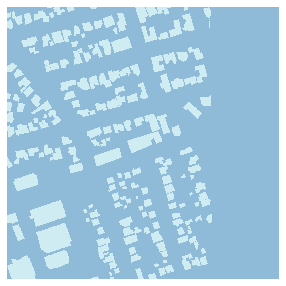

In [22]:
bmask_recon.show(figsize=(5, 5))

### Generate an id for each polygon

In [23]:
uid = uuid4()
uid

UUID('6b9bd3f2-714d-4761-b4b7-2757c662a7a2')

In [24]:
str(uid)

'6b9bd3f2-714d-4761-b4b7-2757c662a7a2'

In [25]:
uids = np.array([str(uuid4()) for _ in polys])

In [26]:
df_polys = pd.DataFrame({'uid':uids, 'polygon':polys})

We now have a table listing the polygons and their id:

In [27]:
df_polys.head()

,uid,polygon
0,8b718ebb-b601-4bb8-81dd-1ea4806cbf0e,"[[398, 1014], [397, 1015], [396, 1015], [395, ..."
1,e4392fb4-96df-4073-bad9-3d17ded13eb5,"[[339, 1014], [338, 1015], [335, 1015], [334, ..."
2,398e9380-840d-40ea-a2d7-d6e681e19e5f,"[[555, 1001], [554, 1002], [551, 1002], [550, ..."
3,a741e63e-a8c0-42ec-82ee-af77f8c05408,"[[390, 996], [389, 997], [388, 997], [387, 998..."
4,899d19bf-83f1-4cf1-b872-f34520f5c7f4,"[[419, 983], [418, 984], [415, 984], [414, 985..."


### Get *polygon images*

The rectangular part of the original image in which a polygon just fits is called a *polygon* image.  In this section, we look at how to get a polygon image from a polygon and the image in which it sits.

In [28]:
polygon = df_polys.iloc[4].polygon
polygon

array([[419, 983],
       [418, 984],
       [415, 984],
       [414, 985],
       ...,
       [421, 986],
       [420, 985],
       [420, 983],
       [419, 983]], dtype=int32)

In [29]:
posimg = open_image(nposimg)

In [30]:
#export
def crop_by_polygon(img:Image, polygon:np.ndarray, scale_pct=.8):
    '''
    Crop image by polygon
    img: image in which polygon lies.
    polygon: numpy array of (x, y) coordinates of vertices of polygon.
    '''
    width, height = img.size
    xs, ys = zip(*polygon)
    xmin, xmax, ymin, ymax = min(xs), max(xs), min(ys), max(ys)
    dx, dy = xmax - xmin, ymax - ymin
    ddx, ddy = scale_pct * dx, scale_pct * dy
    xmin, xmax = int(np.floor(xmin - ddx)), int(np.ceil(xmax + ddx))
    ymin, ymax = int(np.floor(ymin - ddy)), int(np.ceil(ymax + ddy))
    xmin, xmax = max(xmin, 0), min(xmax, width)
    ymin, ymax = max(ymin, 0), min(ymax, height)
    return Image(img.data[:,ymin:ymax,xmin:xmax])

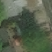

In [31]:
crop_by_polygon(posimg, polygon)

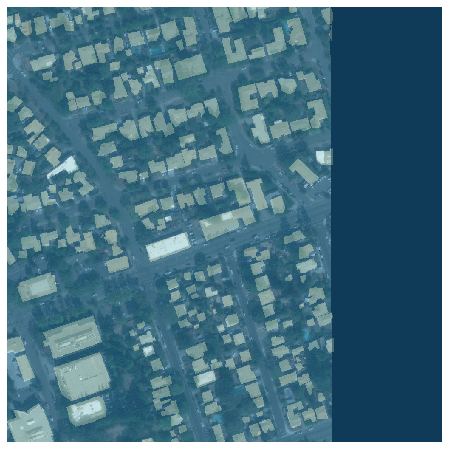

In [32]:
_, ax = plt.subplots(figsize=(8, 8))
posimg.show(ax)
bmask.show(ax, alpha=.5)

### Create damage classification dataset for training

Get all the polygon images from all the samples in the training set, and save them in folders named after their damamge level.  

For each sample:
1. Get the polygons from the post-disaster annotation.
2. Use the polygons to crop the post-disaster image.
3. Generate a unique id for each polygon.
4. Save each polygon image to a file named after its unique id.
5. Get the damamge level for each polygon.
6. Record each polygon, along with its id and damamge level.

In [33]:
idx = 523

In [34]:
nposimg, nposlab = nposimgs[idx], nposlabs[idx]

In [35]:
posimg = open_image(nposimg)

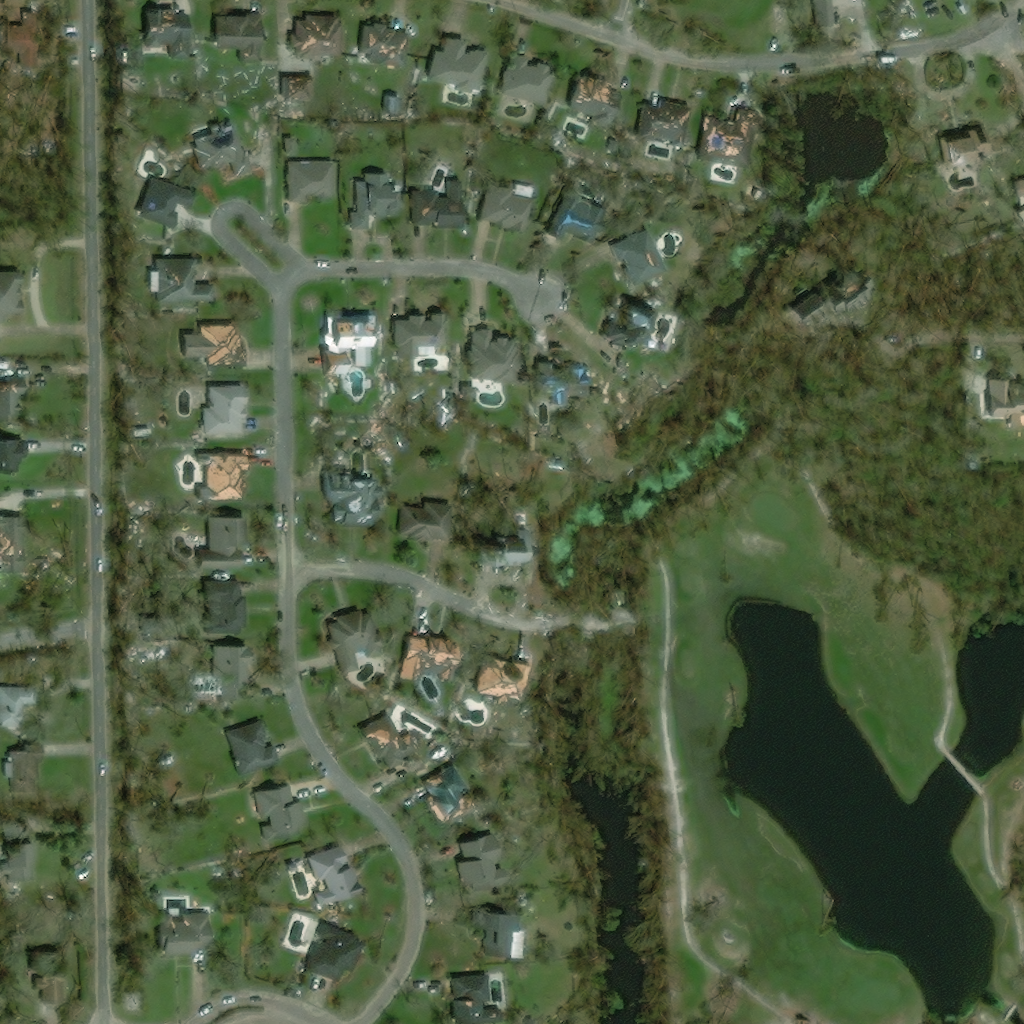

In [36]:
posimg

In [37]:
features = load_features(nposlab)

In [38]:
df_polys = features2df(features)

In [39]:
df_polys

,feature_type,subtype,uid,wkt
0,building,no-damage,d4347848-c9d2-43b2-961a-24cd4aa12d27,"POLYGON ((128.45002791653 30.63078146451458, 1..."
1,building,minor-damage,a5e7f8e5-4779-48be-a2b9-a82752a5f3ff,"POLYGON ((145.6793695084561 11.05523486537903,..."
2,building,no-damage,32d65f6e-276f-46af-a3d0-c301e7da7af7,"POLYGON ((214.1168498913994 14.54588758628003,..."
3,building,minor-damage,0da36c0b-04fd-4770-a854-cfbfb641a164,"POLYGON ((296.5009011133445 31.97374886194391,..."
4,building,minor-damage,58ff17e6-60eb-4778-a786-998dcb710d69,"POLYGON ((284.2001041225392 74.65603239773938,..."
...,...,...,...,...
62,building,no-damage,32c35711-9da8-474f-af4c-4f35e502e97b,"POLYGON ((1023.055636333416 217.2994140469055,..."
63,building,no-damage,e25f2b71-a13c-4ff7-a00f-6301f7e40d98,"POLYGON ((1023.055612980116 188.2785039381305,..."
64,building,no-damage,d27a7a74-271e-4423-868d-aa2391e2bd1f,"POLYGON ((131.4052728724366 989.3682907250106,..."
65,building,no-damage,f263263a-bdbe-4f42-b651-d5c1516bf7aa,"POLYGON ((31.97708792311021 950.8676296372972,..."


In [40]:
idx = 35

In [41]:
r = df_polys.iloc[idx]

In [42]:
#export
def wkt2array(wkt:str):
    '''
    Convert well-known text representation string 
    to array of (x,y) coords
    '''
    poly = shapely.wkt.loads(wkt)
    poly = shapely.geometry.mapping(poly)
    poly = np.array(poly['coordinates'][0], dtype=np.int32)
    return poly

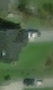

In [43]:
poly = wkt2array(r.wkt)
polyimg = crop_by_polygon(posimg, poly, )
polyimg

In [44]:
fname = f'{r.uid}.png'
fpath = SOURCE/'classification_images'/fname
fname, fpath

('c9f80c42-4d48-4cc7-94a8-c084a308fb2b.png',
 PosixPath('data/train/classification_images/c9f80c42-4d48-4cc7-94a8-c084a308fb2b.png'))

Test save this polygon image

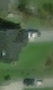

In [45]:
polyimg.save(Path('tmp')/fname)
open_image(Path('tmp')/fname)

We will also create a dataframe/csv to keep track of the damage level of each polygon image.

In [81]:
os.makedirs(SOURCE/'classification_images', exist_ok=True)

In [91]:
#export
def generate_classification_train(nposimgs, nposlabs, path=None, csv=None):
    '''
    Generate polygon images and a .csv file listing them and their damage level.
    nposimgs: list
      list of image paths
    nposlabs: list
      list of json paths, corresponding to the paths in nposimgs.
    path: Path/str
      Path to save image files
    csv: Path/str
      Path to save csv file
    '''
    assert len(nposimgs) == len(nposlabs)
    df = pd.DataFrame()
    for nposimg, nposlab in progress_bar(list(zip(nposimgs, nposlabs))):
        posimg = open_image(nposimg)
        feats = load_features(nposlab)
        df_polys = features2df(feats)
        for _, r in df_polys.iterrows():
            p = wkt2array(r.wkt)
            img = crop_by_polygon(posimg, p)
            img.save(path/f'{r.uid}.png')
            srs = pd.Series({'uid':r.uid, 'damage':r.subtype})
            df = df.append(srs, ignore_index=True)
    df.to_csv(csv, index=False)

**Run the cell below to generate a damage classification training set.** 

In [48]:
%%time

npreimgs = pre_img_fpaths(get_image_files(SOURCE/'images'))
nposimgs = [pre2post_fpath(n) for n in npreimgs]
nposlabs = [img2label_fpath(n) for n in nposimgs]

path = SOURCE/'classification_images'
csv = 'class_labels_train.csv'
#generate_classification_train(nposimgs, nposlabs, path=path, csv=csv)

CPU times: user 79.6 ms, sys: 12.7 ms, total: 92.3 ms
Wall time: 113 ms


In [49]:
idx = 8

df = pd.read_csv(path/csv)
open_image(SOURCE/'classification_images'/f'{df.uid[idx]}.png')

FileNotFoundError: [Errno 2] File b'data/train/classification_images/class_labels_train.csv' does not exist: b'data/train/classification_images/class_labels_train.csv'

In [94]:
len((SOURCE/'classification_images').ls()), df.shape

(162789, (162787, 2))

# -fin

In [74]:
! python notebook2script.py 02c_bmask_to_polygons.ipynb

Converted 02c_bmask_to_polygons.ipynb to xview2comp/nb_02c.py
